In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
from tinygp import kernels, GaussianProcess
import jax
from jax.scipy import linalg
import jax.numpy as jnp
import optax
from tqdm.notebook import trange, tqdm
from tinygp.noise import Diagonal
from tqdm import notebook
jax.config.update("jax_enable_x64", True)
plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
import pickle
import pandas as pd
from CARPoolGP import *
from NDfuncs import *

# N-D model

## Creating the model

We want to generate a model that interpolates across the 1P set. Then we want to try to use carpool with this model?

In [2]:
# Lets read in only the most massive halo
data = np.load('Data/first_100.npz')
Y_mean = np.log10(data['Y'][:, 0])
Mass = np.log10(data['M'][:, 0]*1e10)
Y_var =  np.var( np.log10(data['Y'][:, 1:10]), axis=-1)

param_df = pd.read_csv('Data/all_params.txt', delimiter='\s+')
LH = param_df.iloc[:1000, 1:-1]
LH['M'] = Mass
X = np.array(LH.iloc[:,:])

Now lets build a gaussian process which interpolates across this

In [3]:
import jaxopt
from tinygp import GaussianProcess, kernels, transforms


def train_gp(nparams, build_gp_func, X, y, err):
    @jax.jit
    def loss(params):
        return -build_gp_func(params, X, err).log_probability(y)

    params = {
        "log_amp": np.float64(0.0),
        "log_scale" : np.zeros(nparams),
        "log_jitter": 0.0,
    }
    solver = jaxopt.ScipyMinimize(fun=loss)
    soln = solver.run(params)
    return build_gp_func(soln.params, X, err)


def build_gp_uncorr(params, X, err):
    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        jnp.exp(params["log_scale"]), kernels.ExpSquared()
    )
    return GaussianProcess(kernel, X, diag=jnp.exp(params["log_jitter"]))

In [4]:
uncorr_gp = train_gp(7, build_gp_uncorr, X, Y_mean, Y_var)

In [5]:
sigma = np.sqrt(uncorr_gp.noise.diag[0])

In [6]:
data = np.load('Data/first_100_1P.npz')
args = [-1,-2,-3,-4,-5, 0, 1, 2, 3, 4, 5]
args_M = [-1, -2, -3, -4, -5, 1, 2, 3, 4, 5]
T = np.log10(data['Y'])[:, 0].reshape(6, -1)
M = np.log10(data['M'][:, 0].reshape(6, -1)[:, args_M].flatten()*1e10)
param_df = pd.read_csv('Data/params.txt', names = ['n', 'Om0', 's8', 'AASN1','AAGN1', 'AASN2', 'AAGN2', '_'])
param_df = param_df.iloc[:, 1:-1]
param_df['M'] = M

In [7]:
model = uncorr_gp.predict(Y_mean, np.array(param_df))

Text(0, 0.5, '$\\log_{10}(T) [K]$')

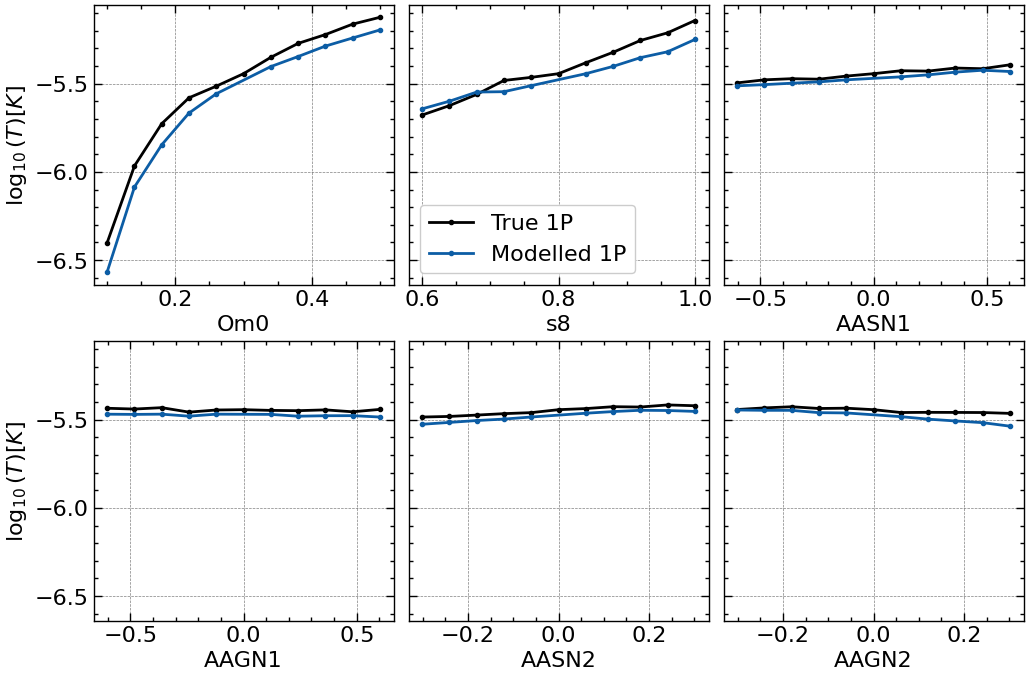

In [8]:
# fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(12, 8), gridspec_kw={'wspace':0.05})
names = list(param_df.columns)
for i, m in enumerate(model.reshape(6,-1)):
    x = np.unique(param_df.iloc[:, i])
    if i>1:
        x = np.log10(x)
    axs[i//3, i%3].plot(x, T[i][args], 'k.-', label='True 1P')
    x = np.delete(x, 5)
    axs[i//3, i%3].plot(x, m, '.-', label='Modelled 1P')
    axs[i//3, i%3].set_xlabel(names[i])
axs[0,1].legend()
axs[0,0].set_ylabel('$\log_{10}(T) [K]$')
axs[1,0].set_ylabel('$\log_{10}(T) [K]$')

In [17]:
def chi2(data, model, cov):
    inv_cov = 1/np.diag(cov)
    return np.sum((data - model)**2* inv_cov)

In [9]:
def CompareCARPool(param_df, uncorr_gp, Y_mean, Groups, test_theta=None, N_CP=9, seed=1993, iters=300):
    
    theta = generate_theta(param_df, N=N_CP, seed=seed)
    
    data, intrinsic_noise = generate_model(theta, 
                                           uncorr_gp, 
                                           Y_mean, 
                                           seed=seed+1)
    
    theta_R, surrogate_data, surrogate_raw = generate_surrogates(
                                                    theta, 
                                                    intrinsic_noise, 
                                                    uncorr_gp,
                                                    Y_mean, 
                                                    Groups=Groups)
    
    paramsCP = fit_CP(theta, theta_R, 
                      data, surrogate_data,iters=iters)
    
    double_theta = generate_theta(param_df, 
                                  N=N_CP+1, 
                                  seed=seed)
    
    double_data, double_noise = generate_model(double_theta, 
                                               uncorr_gp, 
                                               Y_mean, 
                                               seed=seed-1)
    
    paramsGP = fit_doubleGP(double_theta, double_data, iters=iters)
    
    if not test_theta:
        test_theta=np.array(param_df)
        test_data = uncorr_gp.predict(Y_mean, test_theta)
        
    pred_meanCP, pred_varCP = predict_CP(paramsCP, theta, theta_R, data, surrogate_data, test_theta.T)
    pred_meanGP, pred_varGP = predict_GP(paramsGP, double_theta, double_data,  test_theta.T)
    
    means = [pred_meanCP, pred_meanGP]
    var   = [pred_varCP, pred_varGP]
    params = [paramsCP, paramsGP]
    
    return means, var, params

In [25]:
seeds = np.arange(100, 200, 5)

In [29]:
groups = 2**np.arange(10)
seeds = np.arange(100, 200, 5)

M = np.zeros((10, 20, 2, 60))
V = np.zeros((10, 20, 2, 60,60))
P = []

for i, group in enumerate(groups):
    for j, seed in enumerate(seeds):
        means, var, params = CompareCARPool(param_df, uncorr_gp, Y_mean, 
                                            Groups=group, test_theta=None, N_CP=9, 
                                            seed=seed, iters=300)
        model = uncorr_gp.predict(Y_mean, np.array(param_df))
        print(f'chi2 for CARPool = {chi2(model, means[0], var[0])}')
        print(f'chi2 for GP = {chi2(model, means[1], var[1])}')
        
        M[i,j] = means
        V[i,j] = var
        P.append(params)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 112.51994668561771
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 32.42099101224173
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.646220317904094
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 27.923847482697276
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 101.08538978612776
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 45.789712623197914
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 57.136607851763785
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 68.0932646121888
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.651558334664648
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 43.84155374146167
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 52.12141967498842
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 61.42421738052038
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 49.35368192326504
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.397306257747697
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 41.379628851343924
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.085687705571448
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 43.48090086184192
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 341.70471312952066
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 90.54577484656593
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 8.433074393184716
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 69.04184347249841
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 64.26023742970833
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 13.953719934289536
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 25.307649338639543
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 69.21276937272582
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 24.352174658931858
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 46.812506929334646
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 75.62109438710368
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 10.860787376894505
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.443370308235615
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 52.02069548806534
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.12319903446438
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 52.05063199336698
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.145816329863752
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 23.474788326859226
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.029730824600186
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 33.68196848771355
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 240.9040404358766
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 59.60675434853328
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 20.911049080349894
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 99.3986801110878
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 36.76714189319071
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.78326806151431
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 20.560944215961772
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 32.91486848274171
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 5.798460078860091
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 109.37174167026038
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 40.083361830803625
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.275172365236042
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 32.934947381053945
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 66.94649123433243
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 22.46967857220363
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 75.66371164918729
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 9.774986384140941
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 43.99201343724099
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 21.846085560415553
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 40.00323998216111
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 150.34213878235886
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 44.76577584398977
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 24.354766825595725
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 49.87177350430743
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 45.669593311108045
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 9.727098859921892
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 20.939267677663715
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 20.123066221761214
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 4.417157303189478
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 131.2827211105205
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.01508142042629
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.668364313571008
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 42.24955926840525
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 75.5571920800896
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.266541924086914
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 56.35542718244971
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 10.634077739405845
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 41.929829459809184
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 23.030050601085385
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 46.020203323182756
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 137.25185917778052
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.86988022265233
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 19.53038208754954
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.31979635777944
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 32.57370844627479
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 9.404299487331704
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.645265909094352
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 9.377793892732079
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 5.839642287996325
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 106.62936639582409
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 16.944455186772135
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.455063948623295
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.845726924989634
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 63.69194347540568
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.149764815031046
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 47.55450240772221
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 19.516286383658024
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 33.407167894972844
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.272301498519612
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 49.51860431938755
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 89.28243256677682
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 25.37049506014881
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 19.7164562502147
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 27.830426486713176
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 39.11039173202194
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.892096544333604
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.265092187894865
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 7.287997805553621
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 9.422620705603098
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 71.30097429562261
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 17.252436000187807
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 13.076340110308944
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.09331755895471
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.220724694299758
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 24.533318570316787
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.736844914018704
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 8.244939058634131
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 4.680143413215543
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 13.694062780658118
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 57.616422817730914
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 23.821554388199576
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 7.330510915357086
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 19.43448423063342
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 28.374409612093444
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 13.70418432491467
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 13.446499160631596
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 10.43122387709658
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 6.5991379454794235
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.74219861361051
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.440423800598214
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 17.86304587397591
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 7.169580107886594
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.801582881456914
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 16.473648137320012
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.319950165215715
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 27.886742979899058
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 28.895964344893912
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 4.5960687215166685
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.92576333649929
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.51685296867828
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 51.1802013448368
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 3.2031582239279017
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.35127423647671
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 30.686709586009883
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.840595756177077
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 22.20102709800831
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.363502673092599
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 16.26710963345592
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 25.602960641229046
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.872345453639795
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 16.644188062274875
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 12.728531948489971
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.093753597404817
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.036477031167323
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.568120193979322
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 39.481645043665935
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 33.42341416291049
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 11.979114122076032
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.40458780366408
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 23.572404720380867
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 20.45071953509786
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 5.821450145836552
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 40.142329892985764
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 24.28206410579685
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 10.099456525075306
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 24.828081653620508
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 29.47006791109616
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 52.54772079387175
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.52080245826825
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 15.567077912173888
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 28.56552465553289
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 14.57357665235524
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 22.677814685991223
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 18.50970544385336
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 45.68342222831344
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 58.40877912316136
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 33.24132090039482
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 33.844320935575276
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 43.88124795987453
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 29.168857850931005
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 45.55404200274057
chi2 for GP = 26.39572307351267


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 199.51968185360278


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 22.736779407591563


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.44131404471509
chi2 for GP = 40.42364687493547


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.16334949309465
chi2 for GP = 38.82241458278622


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 131.11649115861337


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 41.321430948316184
chi2 for GP = 17.24104349834855


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 39.7072617402025
chi2 for GP = 297.14945466056304


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.06715971901215
chi2 for GP = 69.5685181073492


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 34.164982603828065
chi2 for GP = 22.646560725590586


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.9814483712873
chi2 for GP = 32.25473244543766


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 43.54056325701809
chi2 for GP = 28.382686524620315


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 41.62732337445932
chi2 for GP = 64.11216479547106


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 46.32035988218465
chi2 for GP = 119.0472426762231


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 8.559542370108705


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.18358672017395
chi2 for GP = 66.72428668312348


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 38.75449777410978
chi2 for GP = 30.518468513425418


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 46.45895122756326


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 37.669174491349565
chi2 for GP = 35.946833636122506


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = nan
chi2 for GP = 99.72448627675882


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

chi2 for CARPool = 36.826068508372856
chi2 for GP = 26.39572307351267


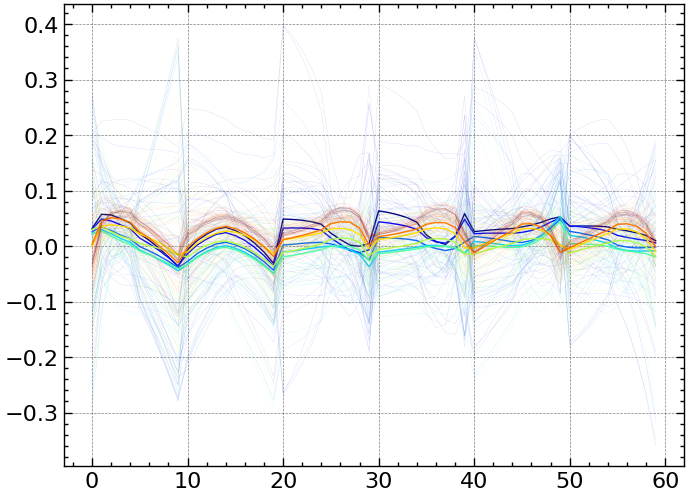

In [55]:
cs = plt.cm.jet(np.linspace(0, 1, 10))
chi2s = np.zeros((10, 20))
chi2s_GP = np.zeros((10, 20))

for i in range(10):
    for j, mi in enumerate(M[i]):
        plt.plot(model- mi[0], lw=0.2, c=cs[i], alpha=0.2)
        chi2s[i, j] = chi2(model, mi[0], V[i,j,0])
        chi2s_GP[i,j] = chi2(model, mi[1], V[i,j,1])
    plt.plot(model  - np.mean(M[i, :, 0], axis=0),'-', c=cs[i], lw=1)
# plt.plot(model, 'ko')

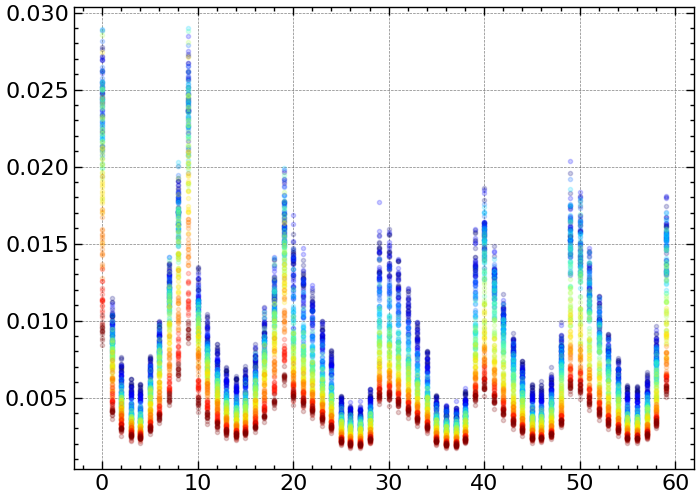

In [54]:
cs = plt.cm.jet(np.linspace(0, 1, 10))
chi2s = np.zeros((10, 20))
chi2s_GP = np.zeros((10, 20))

for i in range(10):
    for j, mi in enumerate(V[i]):
        plt.plot(np.diag(mi[0]), '.', c=cs[i], alpha=0.2)
#         chi2s[i, j] = chi2(model, mi[0], V[i,j,0])
#         chi2s_GP[i,j] = chi2(model, mi[1], V[i,j,1])
#     plt.plot(np.mean(np.diag(V[i, :, 0]), axis=0),'-', c=cs[i], lw=1)
# plt.plot(model, 'ko')

(0.0, 2.0)

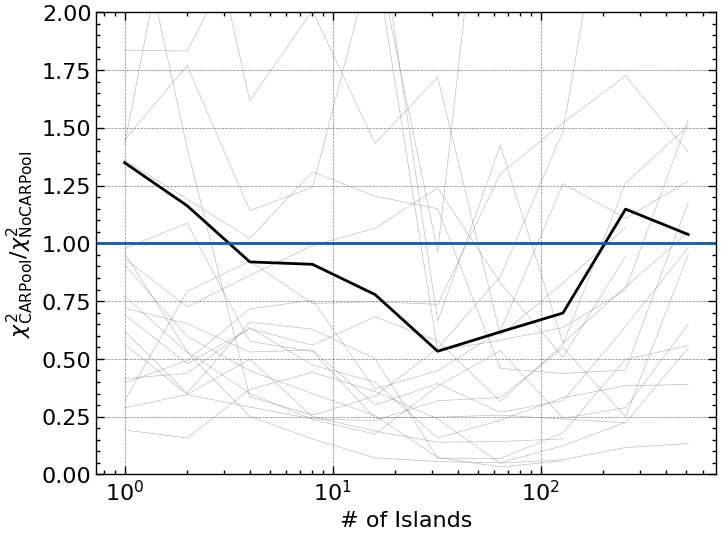

In [60]:
for i in range(20):
    plt.semilogx(groups, chi2s[:, i]/chi2s_GP[:, i], alpha=0.5, c='grey', lw=0.5)
#     plt.loglog(groups, , alpha=0.5, c='g', lw=0.5)
plt.plot(groups, [np.mean((chi2s/chi2s_GP)[i, ~np.isnan(chi2s[i]/chi2s_GP[i])]) for i in range(10)], c='k')
# plt.axhline(np.mean(chi2s_GP), c='k')
plt.axhline(1)
plt.xlabel('# of Islands')
plt.ylabel(r'$\chi^2_{\rm CARPool}/\chi^2_{\rm No CARPool}$')
plt.ylim(0, 2)

Text(0, 0.5, '$\\log_{10}(Y) [Mpc^2]$')

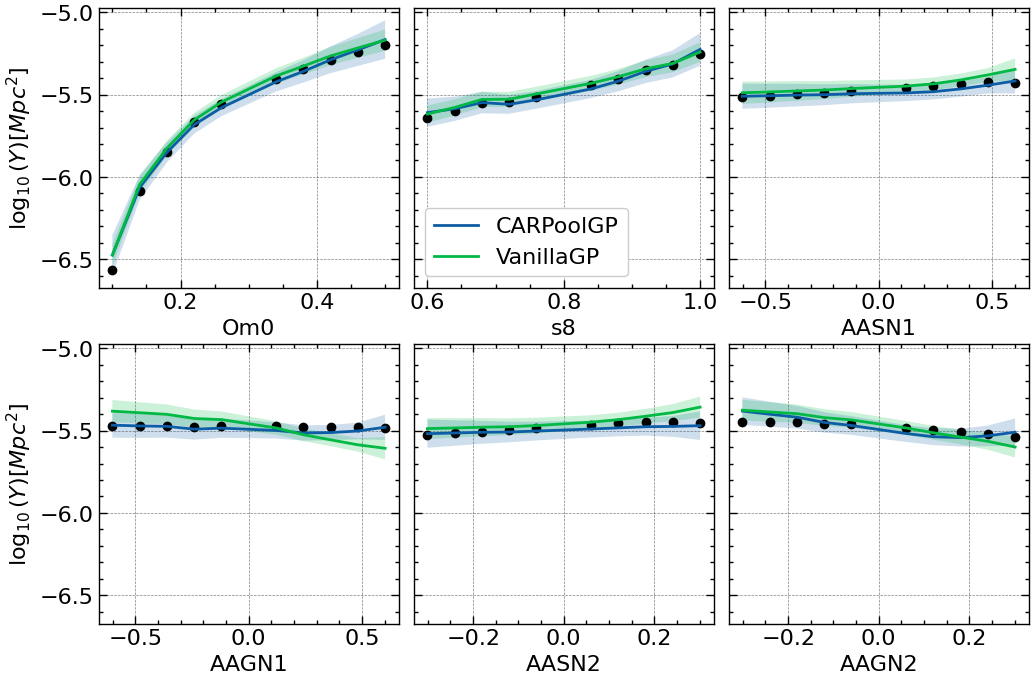

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=True, figsize=(12, 8), gridspec_kw={'wspace':0.05})
pred_meanCP = means[0].reshape(6, -1)
pred_meanGP = means[1].reshape(6, -1)
pred_stdCP = np.sqrt(np.diag(var[0])).reshape(6, -1)
pred_stdGP = np.sqrt(np.diag(var[1])).reshape(6, -1)
names = np.array(param_df.columns)
for i, m in enumerate(model.reshape(6,-1)):
    x = np.unique(param_df.iloc[:, i])
    x = np.delete(x, 5)
    if i>1:
        x=np.log10(x)
    axs[i//3, i%3].plot(x, m, 'ko')
    axs[i//3, i%3].plot(x, pred_meanCP[i], '-', label='CARPoolGP')
    axs[i//3, i%3].plot(x, pred_meanGP[i], '-', label='VanillaGP')
    axs[i//3, i%3].fill_between(x, pred_meanCP[i] + pred_stdCP[i], pred_meanCP[i] - pred_stdCP[i], alpha=0.2)
    axs[i//3, i%3].fill_between(x, pred_meanGP[i] + pred_stdGP[i], pred_meanGP[i] - pred_stdGP[i], alpha=0.2)
    axs[i//3, i%3].set_xlabel(names[i])
axs[0,1].legend()
axs[0,0].set_ylabel('$\log_{10}(Y) [Mpc^2]$')
axs[1,0].set_ylabel('$\log_{10}(Y) [Mpc^2]$')